# Interrupted time series analysis on the impact of introducing hepA vaccine into the mandatory vaccination schedule.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

/home/bavio/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import warnings; warnings.simplefilter('ignore')

## 1. Introduction

With the raising of the so call *antivaxxers* groups around the world, we wanted to see what the data has to tell us about the impact of vaccines as an intervention to stop vaccine-preventable diseases. On june 1 2005, Argentina's Department of Health introduced the hepatitis A vaccine on the mandatory vaccination schedule [[1]](http://www.scielo.org.ar/scielo.php?script=sci_arttext&pid=S0325-00752013000200011). Hepatitis A (*hepA* from now on) is a disease that could potentially lead to hepatic failure and liver transplantiation in childrens.

#### 1.1.1 Objective

Our aim here is to see the effect of introducing hepA vaccine on the yearly incidence of new cases of hepA.

#### 1.1.2 Data

Our data comes from Buenos Aires City's Statistics and Census Bureau. Both the number of new cases of hepA and the number of vaccines administered comes from public hospitals around the city. Accounting for the missin data, regression analysis will be restricted to the fourteen years periode between 1999 and 2013.

## 2. Pre-analysis

### 2.1 Visualizing incidence of vaccine-preventable diseases over time

In [4]:
vaccine_pd = pd.read_csv('../datasets/vaccine-preventable-diseases.csv')
vaccine_pd = vaccine_pd.set_index('year', drop=True)

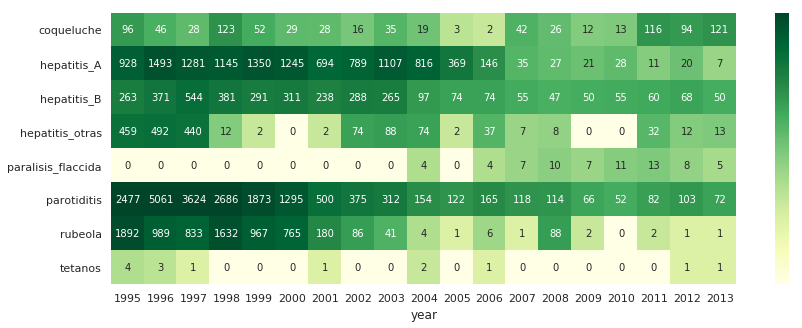

In [5]:
fig, ax = plt.subplots(1,1,figsize=(14,5))
sns.heatmap(np.log(vaccine_pd+0.1).T, robust=True, cmap='YlGn', annot=vaccine_pd.T, fmt="d", ax=ax, cbar_kws={'ticks':[]})
plt.show()

**Figure one:** Heatmap showing the number of new cases of different vaccine-preventable diseases. All cases reported are from public hospitals located Buenos Aires' city. Darker colors represent bigger number of reported cases. 

### 2.2 Visualizing yearly hepA vaccination numbers

In [6]:
vaccine_records = pd.read_csv('../datasets/vaccination-records.csv')
vaccine_records = vaccine_records.set_index('year', drop=True)

In [7]:
mask = ['antihepatitis_A_peds', 'antihepatitis_A_adul', 'antihepatitis_A_brote']
vaccine_records = vaccine_records[mask]

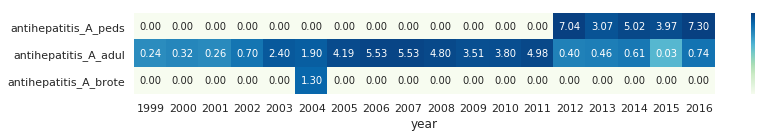

In [8]:
fig, ax = plt.subplots(1,1,figsize=(13,1.5))
sns.heatmap(np.log(vaccine_records.T+0.1), robust=True, annot=np.divide(vaccine_records.T,10000),
            fmt=".2f", cmap='GnBu', ax = ax, cbar_kws={'ticks':[]})
plt.show()

**Figure two:** Heatmap showing yearly vaccination absolute numbers in a ten thousents scale (one being equal to ten thousents).

### 2.3 Setting the dataframe for analysis

In [9]:
vaccine_records['antihepatitis_A_peds'] += vaccine_records['antihepatitis_A_adul']
vaccine_records['antihepatitis_A_peds'] += vaccine_records['antihepatitis_A_brote']
vaccine_records.rename(columns={'antihepatitis_A_peds':'antihepatitis_A'}, inplace=True)

In [10]:
data = pd.DataFrame({'year':range(1995,2017)})

In [11]:
study_period = range(1999,2014)

In [13]:
data = data.merge(vaccine_records['antihepatitis_A'].reset_index(), on='year', how='left')
data = data.merge(vaccine_pd['hepatitis_A'].reset_index(), on='year', how='left')
data = data.rename(columns={'antihepatitis_A':'vaccines', 'hepatitis_A':'cases'})
data = data.set_index('year')

In [20]:
data['vaccines_sum'] = data.vaccines.cumsum()

In [21]:
data.loc[1999:2001]

,vaccines,cases,vaccines_sum
year,,,
1999,2355.0,1350.0,2355.0
2000,3173.0,1245.0,5528.0
2001,2600.0,694.0,8128.0


## 3. Analysis

First, let's try to use *the power of viz* to set the narrative that we want to tell.

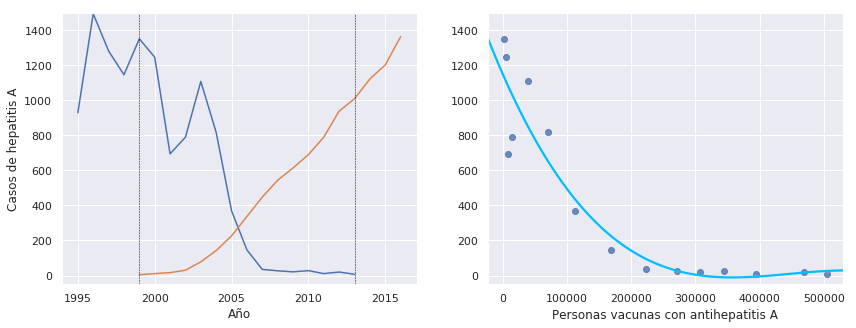

In [29]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

sns.lineplot(data['cases'].index, data['cases'], ax=ax[0])
sns.lineplot(data['vaccines_sum'].index, np.divide(data['vaccines_sum'],500), ax=ax[0])

ax[0].axvline(1999, color='black', lw=0.5, ls='--')
ax[0].axvline(2013, color='black', lw=0.5, ls='--')
ax[0].set_ylabel('Casos de hepatitis A')
ax[0].set_xlabel('Año')
ax[0].set_ylim(-50,1500)

sns.regplot(data.loc[study_period, 'vaccines'].cumsum(), data.loc[study_period, 'cases'], 
            order=3, ci=False, ax=ax[1], line_kws={"color": "deepskyblue"})

ax[1].set_ylim(-50,1500)
ax[1].set_xlabel('Personas vacunas con antihepatitis A')
ax[1].set_ylabel('')

plt.show()

**Figure three:** On the left, a line plot shows the yearly number of both the cases of hepA and the number of vaccines administered to the public, the latter is in a per hundreds scale. On the right, a scatter plot shows the relationship between the number of vaccine administered and the number of hepA cases on that year.

### 3.1 Reggressing the number of new cases by number of vaccinations from 1999 to 2013

In [43]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [188]:
model = smf.glm('cases ~ I(vaccines_sum/10000)', 
                family=sm.families.Poisson(), 
                data = data).fit(cov_type='HC3')

In [189]:
print(str(model.summary())[790:])

                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   7.1210      0.114     62.413      0.000       6.897       7.345
I(vaccines_sum / 10000)    -0.1130      0.009    -11.970      0.000      -0.131      -0.094


#### 3.1.1 Interpreation

Fo every 10000 people that are vaccinated, the incidence of hepA on the population decreases by 0.89 (CI95 0.87 - 0.91).

### 3.2 Interrupted time series analysis: A quasi-experimental design

ITT described here [[1]](https://academic.oup.com/ije/article/46/1/348/2622842)[[2]](https://www.bmj.com/content/350/bmj.h2750)

In [33]:
itt = pd.DataFrame({'cases':data.cases.loc[range(1995,2014)]})

Add time to the database.

In [36]:
itt['time'] = 1
itt['time'] = itt['time'].cumsum()

Add a dummy variable representing the post-intervation period.

In [53]:
itt['intervention'] = 0
itt.loc[range(2005,2014), 'intervention'] = 1

2004 to 2006 is defined as a transition period.

In [41]:
itt['exclusion'] = 0
itt.loc[range(2004,2007), 'exclusion'] = 1

In [75]:
itt.loc[itt['exclusion']!=1, 'time'] = range(1,17)

In [190]:
model = smf.glm('cases ~ time + intervention + time:intervention', 
                family=sm.families.Poisson(), 
                data = itt.loc[itt['exclusion']!=1]).fit(cov_type='HC3')

In [191]:
print(str(model.summary())[790:])

                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.1968      0.161     44.717      0.000       6.881       7.512
time                 -0.0370      0.029     -1.264      0.206      -0.094       0.020
intervention         -1.7841      0.546     -3.265      0.001      -2.855      -0.713
time:intervention    -0.1494      0.056     -2.657      0.008      -0.260      -0.039


#### 3.2.1 Interpretation

Since the introduction of the hepA vaccine on the mandatory vaccination schedule cases of hepA have decreased by 83% (IRR: 0.16, CI95: 0.05 - 0.49) when comparing the periods 1995-2004 vs 2006-2013.

In [93]:
itt['wo_intervention'] = model.predict(pd.DataFrame({'time':range(1,20), 'intervention':0})).tolist()
itt['w_intervention'] = model.predict(pd.DataFrame({'time':range(1,20), 'intervention':1})).tolist()

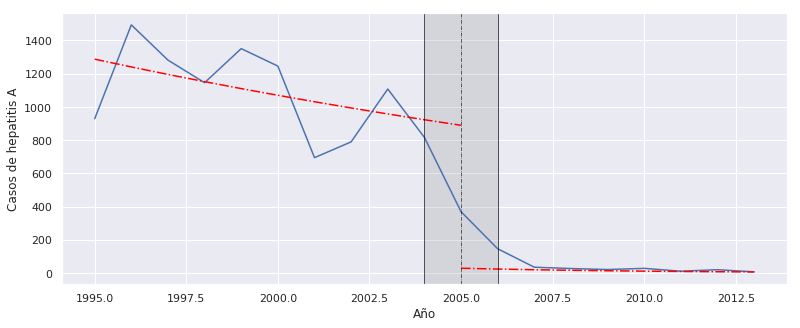

In [155]:
fig, ax = plt.subplots(1,1,figsize=(13,5))

sns.lineplot(itt.index, itt.cases, ax=ax)
sns.lineplot(itt.loc[range(1995,2006)].index, itt.wo_intervention.loc[range(1995,2006)],
             c='red', ax=ax)
sns.lineplot(itt.loc[range(2005,2014)].index, itt.w_intervention.loc[range(2005,2014)],
             c='red', ax=ax, )

ax.lines[1].set_linestyle("-."); ax.lines[2].set_linestyle("-.")
ax.axvline(2005, c='black', lw=0.6, ls='-.')
ax.axvline(2004, c='black', lw=0.6);ax.axvline(2006, c='black', lw=0.6)
ax.axvspan(2004, 2006, alpha=0.2, color='grey')
ax.set_xlabel('Año'); ax.set_ylabel('Casos de hepatitis A')

plt.show()

### 3.3 Bayes: for those who love it

In [195]:
import pymc3 as pm

In [326]:
with pm.Model() as model:
    alpha = 1.0/data.loc[range(1995,2014)].cases.mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau",lower=0, upper=data.loc[range(1995,2014)].cases.size - 1)
    
    idx = np.arange(data.loc[range(1995,2014)].cases.size)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=data.loc[range(1995,2014)].cases)
    difference = pm.Deterministic('difference', lambda_1 - lambda_2)
    
    step = pm.Metropolis()
    start = pm.find_MAP()
    trace = pm.sample(10000, step=step, start=start, progressbar=True)

logp = -6,517.9, ||grad|| = 6,817.8: 100%|██████████| 9/9 [00:00<00:00, 39.91it/s]   
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:13<00:00, 1595.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


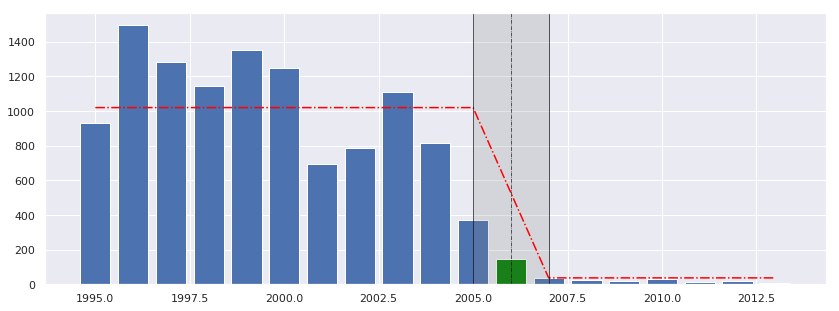

In [334]:
fig, ax = plt.subplots(1,1,figsize=(14,5))

lam1 = trace['lambda_1'].mean()
lam2 =trace['lambda_2'].mean()
line = [lam1] * 11 + [np.mean([lam1, lam2])] + [lam2] * 7

ax.bar(data.cases.index, data.cases)
ax.bar(2006, data.loc[2006, 'cases'], color = 'green')
ax.plot(range(1995,2014), line, color='red', ls='-.')

ax.axvline(2006, c='black', lw=0.6, ls='-.')
ax.axvline(2005, c='black', lw=0.6)
ax.axvline(2007, c='black', lw=0.6)
ax.axvspan(2005, 2007, alpha=0.2, color='grey')
plt.show()

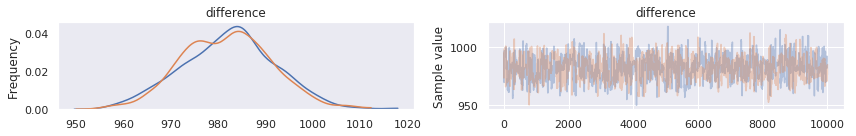

In [332]:
pm.traceplot(trace, varnames=['difference']); plt.show()

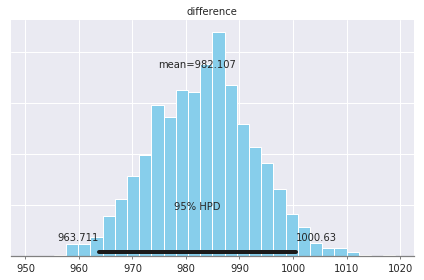

In [333]:
pm.plot_posterior(trace, varnames=['difference']); plt.show()